Utilisez de préférence from scipy.ndimage.convolve1d avec l’option mode=’wrap’ pour obtenir une
convolution circulaire et éviter ainsi les effets de bord.
1. Encodage élémentaire. Codez une fonction encode1d(x) qui prend en entrée un signal 1D x
et renvoie deux signaux résultants du filtrage et du sous-échantillonnage de x par les filtres h1
et h2. Le résultat sera un vecteur y = [y1, y2] de taille N , concaténation de y1 et y2.
2. Décodage élémentaire. Codez une fonction decode1d(y) réalise l’inverse de la fonction
encode1d.
3. Testez vos fonctions en chargeant une image et en les appliquant sur une ligne.
4. Cascade. Réalisez des fonctions encode1d_k(x, k) et decode1d_k(y, k) qui réalisent une
cascade de k encodage ou décodage (voir question 5 du TD). L’encodage sera toujours un
vecteur unique de la même taille que x, contenant les différents vecteurs de détail (issus de h2),
du dernier (de taille 1) au premier (de taille N/2). Testez ces fonctions sur une ligne d’une
image. Modifiez votre fonction pour que si k vaut None, le nombre maximum de décomposition
soit considéré.
5. Faites une expérience de compression : encodage, mise à zéro des coefficients de plus faible
amplitude, décodage, mesure de l’erreur entre le signal reconstruit et le signal origina


In [2]:
from scipy.ndimage import convolve1d
import numpy as np

In [1]:
def encode1d(x):
    x_len = x.size
    y = np.empty_like(x)
    y[:x_len//2] = convolve1d(x, [0.5, 0.5], mode='wrap')[::2]
    y[x_len//2:] = convolve1d(x, [-0.5, 0.5], mode='wrap')[::2]
    return y



In [3]:
def decode1d(y):
    y_len = y.size
    x = np.empty_like(y)
    y1, y2 = y[:y_len//2], y[y_len//2:]
    x[::2] = y1 + y2
    x[1::2] = y1 - y2
    return x

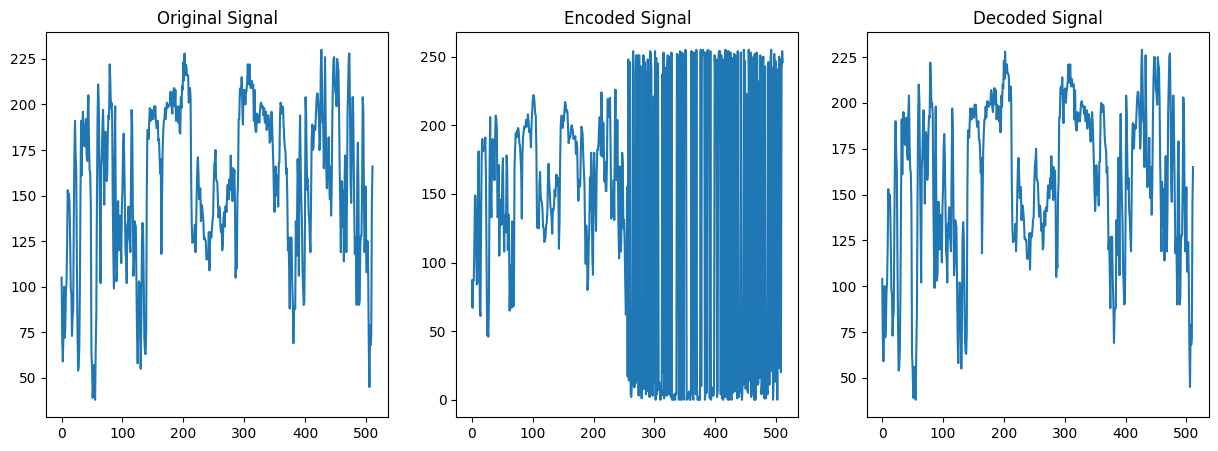

In [4]:
from skimage import io, color

import matplotlib.pyplot as plt

# Load the image
image = io.imread('baboon.png')

x = image[150, :]

# Encode the signal
encoded_signal = encode1d(x)
# Decode the signal
decoded_signal = decode1d(encoded_signal)

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.plot(x)
plt.title('Original Signal')

plt.subplot(1, 3, 2)
plt.plot(encoded_signal)
plt.title('Encoded Signal')

plt.subplot(1, 3, 3)
plt.plot(decoded_signal)
plt.title('Decoded Signal')

plt.show()

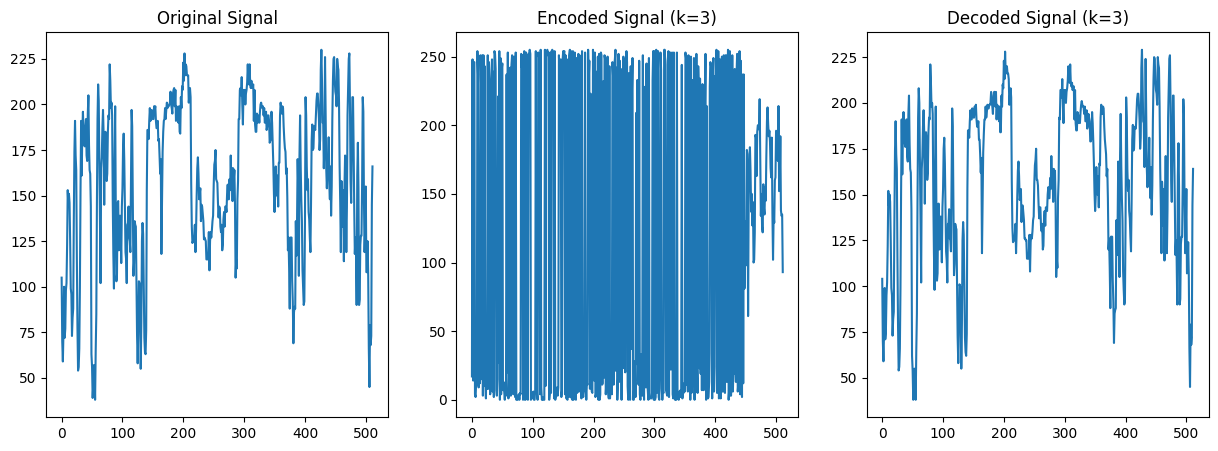

In [5]:
def encode1d_k(x, k=None):
    if k is None:
        k = int(np.log2(len(x)))
    
    details = []
    for _ in range(k):
        x = encode1d(x)
        details.append(x[len(x)//2:])
        x = x[:len(x)//2]
    
    return np.concatenate(details + [x])

def decode1d_k(y, k=None):
    if k is None:
        k = int(np.log2(len(y)))
    
    N = len(y) // (2 ** k)
    x = y[-N:]
    for i in range(k):
        details = y[-(N * (2 ** (i + 1))):-N * (2 ** i)]
        x = np.concatenate((x, details))
        x = decode1d(x)
    
    return x


encoded_signal_k = encode1d_k(x, k=3)
decoded_signal_k = decode1d_k(encoded_signal_k, k=3)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x)
plt.title('Original Signal')

plt.subplot(1, 3, 2)
plt.plot(encoded_signal_k)
plt.title('Encoded Signal (k=3)')

plt.subplot(1, 3, 3)
plt.plot(decoded_signal_k)
plt.title('Decoded Signal (k=3)')

plt.show()

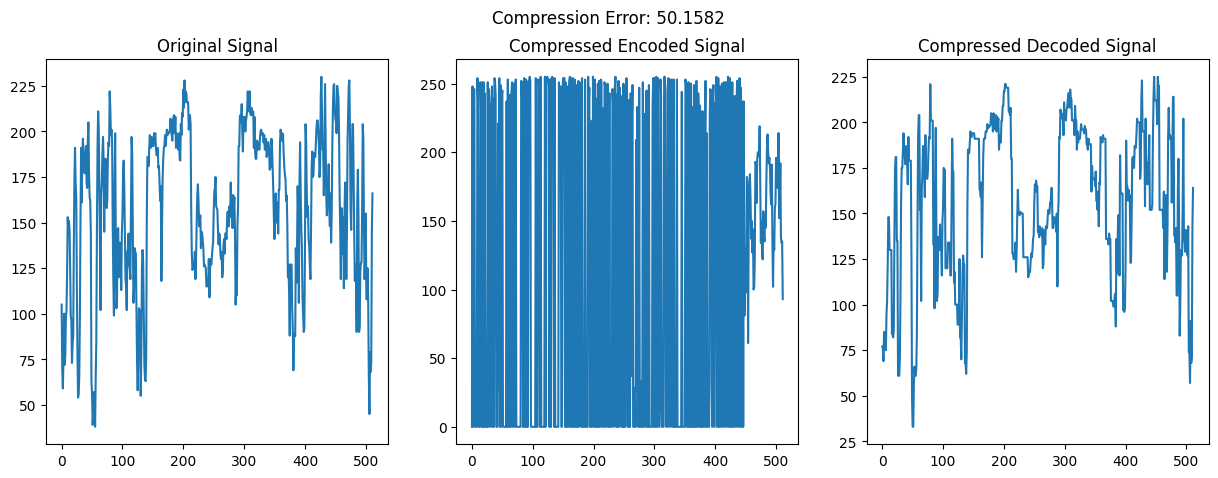

In [6]:
def compress_signal(x, k=None, threshold=0.1):
    # Encode the signal
    encoded_signal = encode1d_k(x, k)
    
    # Set the coefficients with the smallest amplitude to zero
    threshold_value = np.max(np.abs(encoded_signal)) * threshold
    encoded_signal[np.abs(encoded_signal) < threshold_value] = 0
    
    # Decode the signal
    decoded_signal = decode1d_k(encoded_signal, k)
    
    return encoded_signal, decoded_signal

def measure_error(original_signal, reconstructed_signal):
    return np.mean((original_signal - reconstructed_signal) ** 2)

# Perform the compression experiment
compressed_encoded_signal, compressed_decoded_signal = compress_signal(x, k=3, threshold=0.1)
error = measure_error(x, compressed_decoded_signal)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x)
plt.title('Original Signal')

plt.subplot(1, 3, 2)
plt.plot(compressed_encoded_signal)
plt.title('Compressed Encoded Signal')

plt.subplot(1, 3, 3)
plt.plot(compressed_decoded_signal)
plt.title('Compressed Decoded Signal')

plt.suptitle(f'Compression Error: {error:.4f}')
plt.show()